# 04 - Data Imbalance
This notebook performs an exploration of the data imbalancing techniques like undersampling, oversampling, SMOTE. It loads the interim dataset from `data/interim/` folder and perform all the essential steps of this analysis.

## Import libraries and set the paths

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import StratifiedKFold, cross_validate

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection, ClusterCentroids
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

from src.config import PROCESSED_DATA_DIR, FIGURES_DIR
from src.config import NUMERICAL_FEATURES_TO_NORMALIZE, K_BEST_TO_KEEP
from src.config import RANDOM_STATE
from src.utils.io_utils import load_csv
from src.modeling.pipeline import build_base_model_pipeline
from src.modeling.models import get_base_model_and_search_space

2025-06-30 18:46:59.463 | INFO     | src.config:<module>:13 - PROJ_ROOT path is: /home/leonardosaccotelli/Desktop/UNIVERSITA/MACHINE-LEARNING/Dynamic-Ensemble-Learning-for-Credit-Card-Fraud-Detection


In [2]:
processed_path: Path = PROCESSED_DATA_DIR / "creditcardfraud_features.csv"
print(f"interim_path: {processed_path}")

interim_path: /home/leonardosaccotelli/Desktop/UNIVERSITA/MACHINE-LEARNING/Dynamic-Ensemble-Learning-for-Credit-Card-Fraud-Detection/data/processed/creditcardfraud_features.csv


In [3]:
FIGURES_DATA_IMBALANCE_DIR = FIGURES_DIR / "data_imbalance"
FIGURES_DATA_IMBALANCE_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 16})
sns.set_style("whitegrid")
sns.set_palette("tab10")

## Data Loading and Basic Overview
We begin by loading the interim credit card fraud dataset. This is the cleaned file after running data-cleaning phase. It contains cleaned anonymized PCA components (`V1`–`V28`), `Time`, `Amount`, and the `Class` label.

In [5]:
df = load_csv(processed_path, delimiter=",")
print(f"rows, cols = {df.shape}")

rows, cols = (283726, 30)


In [6]:
df.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.014760
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,1.305626
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.939276
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.824306
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.262539


In [7]:
df.groupby("Class")['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

In [8]:
X = df.drop(columns="Class")
y = df["Class"]
print(f"X, y = {X.shape, y.shape}")

X, y = ((283726, 29), (283726,))


## Data preparation

In [9]:
column_names = X.columns

# Map column names to their corresponding indices
column_to_index = {name: idx for idx, name in enumerate(X.columns)}

# Convert the list of column names to indices
# for use in ColumnTransformer
numerical_features_indices = [column_to_index[col]
                              for col in NUMERICAL_FEATURES_TO_NORMALIZE]

X, y = X.to_numpy(), y.to_numpy()
print(f"X, y = {X.shape, y.shape}")

X, y = ((283726, 29), (283726,))


##  Resampling Visualization Function

In [10]:
def visualize_resampling_effect(X, y, resampler, column_names, title: str):
    """
    Visualizes the effect of a resampling technique on class distribution
    using seaborn scatterplot.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Original feature matrix.
    y : array-like of shape (n_samples,)
        Class labels.
    resampler : imblearn BaseSampler or list of (str, transformer)
        Resampling method or a list of steps.
    column_names: list
        Column names to use for plotting.
    title : str
        Descriptive title for the plots.
    """
    # Handle a list of resamplers (custom combo)
    if isinstance(resampler, list):
        resampler = ImbPipeline(resampler)

    unique, frequency = np.unique(y, return_counts=True)
    print(f"Stratification class balance before {name} [class, frequency]: {unique, frequency}")

    # Apply resampling
    X_resampled, y_resampled = resampler.fit_resample(X, y)
    unique, frequency = np.unique(y_resampled, return_counts=True)
    print(f"Stratification class balance after  {name} [class, frequency]: {unique, frequency}")

    # Create dataframes for easier plotting
    df_before = pd.DataFrame(X, columns=column_names)
    df_before["Class"] = y

    df_after = pd.DataFrame(X_resampled, columns=column_names)
    df_after["Class"] = y_resampled

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.scatterplot(df_before,
                    x="V1",
                    y="V2",
                    hue=y,
                    ax=axes[0],
                    alpha=0.6)
    axes[0].set_title(f"{title} - Before")

    sns.scatterplot(df_after,
                    x="V1",
                    y="V2",
                    hue=y_resampled,
                    ax=axes[1],
                    alpha=0.6)
    axes[1].set_title(f"{title} - After")

    plt.suptitle(f"{title}: Effect on Class Distribution", fontsize=20)
    plt.tight_layout()
    plt.savefig(FIGURES_DATA_IMBALANCE_DIR / f"data_imbalance_{title}.png",
                dpi=300)
    plt.show()

## Techniques Explored

We will explore the following resampling methods:

### Over-sampling:
- SMOTE
- ADASYN
- BorderlineSMOTE

### Under-sampling:
- RandomUnderSampler
- EditedNearestNeighbours

### Hybrid (over + under):
- SMOTEENN
- SMOTETomek

### Custom combinations (Under-sampling + Over-sampling)
- RandomUnderSampler + SMOTEENN
    - Under05_SMOTEENN
    - Under10_SMOTEENN
    - Under20_SMOTEENN
- ClusterCentroids + SMOTEENN
- OneSidedSelection + SMOTE
- TomekLinks + SMOTE
- NeighbourhoodCleaningRule + SMOTE

For each method, we visualize the effect and then evaluate a pipeline on 5 Folds StratifiedKFold cross-validation.


In [11]:
resamplers = {
    # Basic oversamplers
    "SMOTE": SMOTE(random_state=RANDOM_STATE),
    "ADASYN": ADASYN(random_state=RANDOM_STATE),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=RANDOM_STATE),

    # Basic undersamplers
    "RandomUnderSampler": RandomUnderSampler(random_state=RANDOM_STATE),
    "EditedNearestNeighbours": EditedNearestNeighbours(),

    # Hybrid samplers
    "SMOTEENN": SMOTEENN(random_state=RANDOM_STATE),
    "SMOTETomek": SMOTETomek(random_state=RANDOM_STATE),

    # Custom combinations (RandomUnderSampler + SMOTEENN)
    "Under05_SMOTEENN": [
        ("undersample", RandomUnderSampler(sampling_strategy=0.05, random_state=RANDOM_STATE)),
        ("resample", SMOTEENN(random_state=RANDOM_STATE))
    ],
    "Under10_SMOTEENN": [
        ("undersample", RandomUnderSampler(sampling_strategy=0.10, random_state=RANDOM_STATE)),
        ("resample", SMOTEENN(random_state=RANDOM_STATE))
    ],
    "Under20_SMOTEENN": [
        ("undersample", RandomUnderSampler(sampling_strategy=0.20, random_state=RANDOM_STATE)),
        ("resample", SMOTEENN(random_state=RANDOM_STATE))
    ],

    # ClusterCentroids + SMOTEENN
    "ClusterCentroids_SMOTEENN": [
        ("undersample", ClusterCentroids(random_state=RANDOM_STATE)),
        ("resample", SMOTEENN(random_state=RANDOM_STATE))
    ],

    # OneSidedSelection + SMOTE
    "OSS_SMOTE": [
        ("undersample", OneSidedSelection(random_state=RANDOM_STATE)),
        ("oversample", SMOTE(random_state=RANDOM_STATE))
    ],

    # TomekLinks + SMOTE
    "Tomek_SMOTE": [
        ("clean", TomekLinks()),
        ("oversample", SMOTE(random_state=RANDOM_STATE))
    ],

    # NeighbourhoodCleaningRule + SMOTE
    "NCR_SMOTE": [
        ("clean", NeighbourhoodCleaningRule()),
        ("oversample", SMOTE(random_state=RANDOM_STATE))
    ],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []

--- Evaluating SMOTE ---
Stratification class balance before SMOTE [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  SMOTE [class, frequency]: (array([0, 1]), array([283253, 283253]))


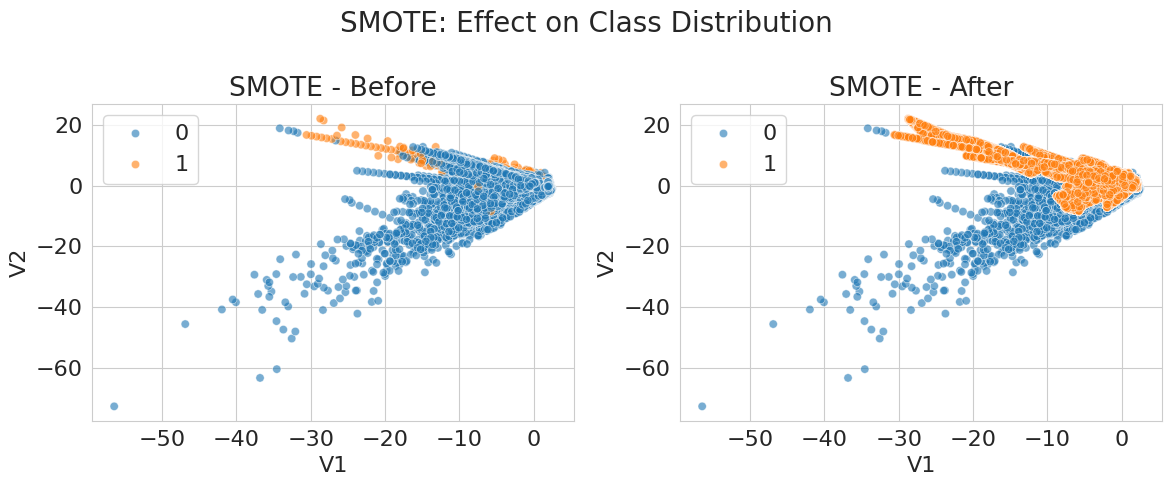

--- Evaluating ADASYN ---
Stratification class balance before ADASYN [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  ADASYN [class, frequency]: (array([0, 1]), array([283253, 283256]))


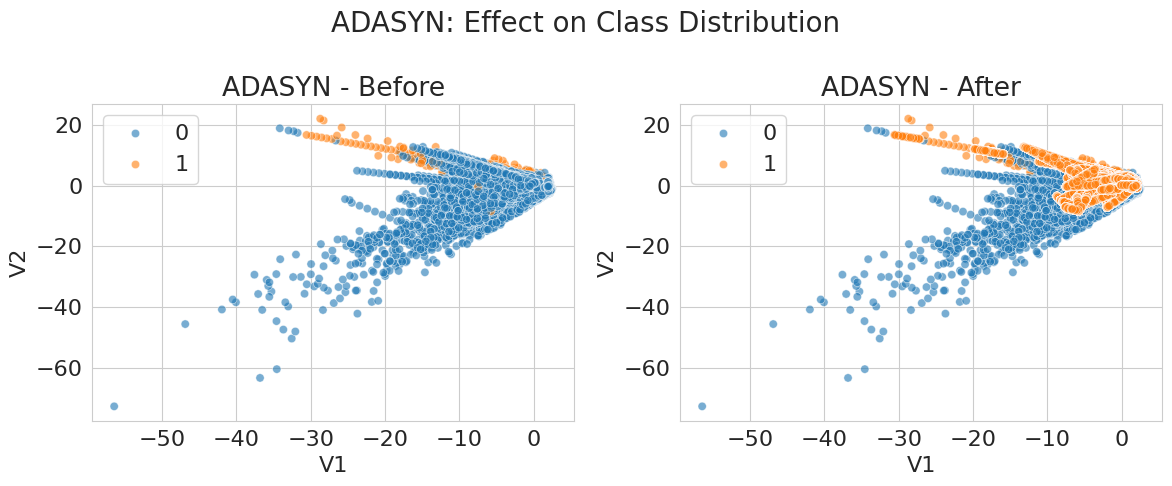

--- Evaluating BorderlineSMOTE ---
Stratification class balance before BorderlineSMOTE [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  BorderlineSMOTE [class, frequency]: (array([0, 1]), array([283253, 283253]))


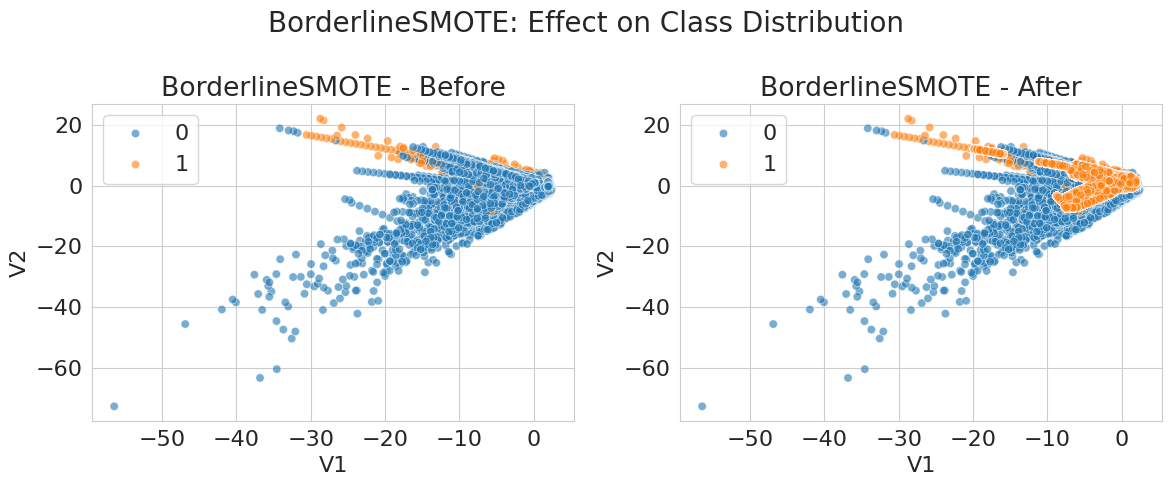

--- Evaluating RandomUnderSampler ---
Stratification class balance before RandomUnderSampler [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  RandomUnderSampler [class, frequency]: (array([0, 1]), array([473, 473]))


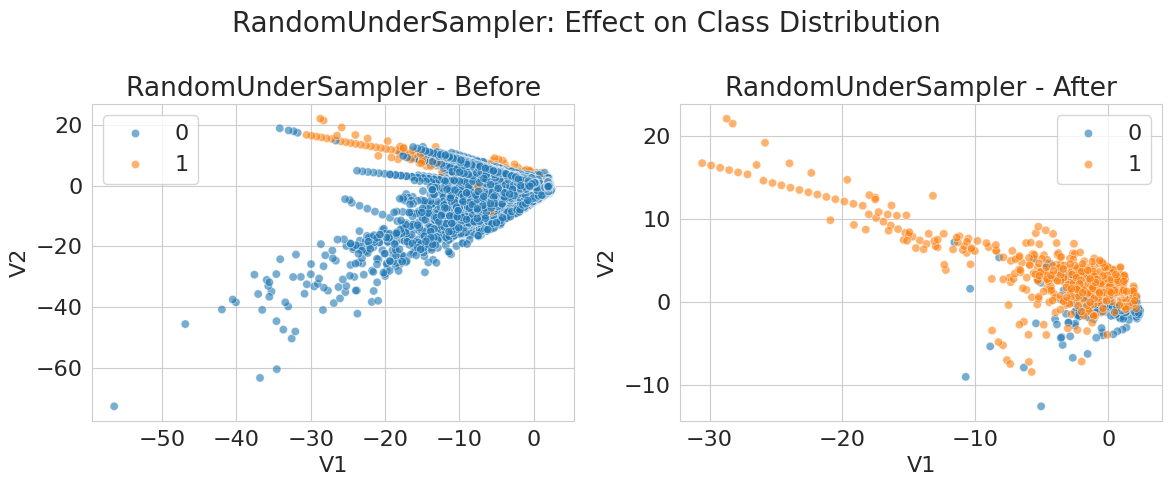

--- Evaluating EditedNearestNeighbours ---
Stratification class balance before EditedNearestNeighbours [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  EditedNearestNeighbours [class, frequency]: (array([0, 1]), array([283086,    473]))


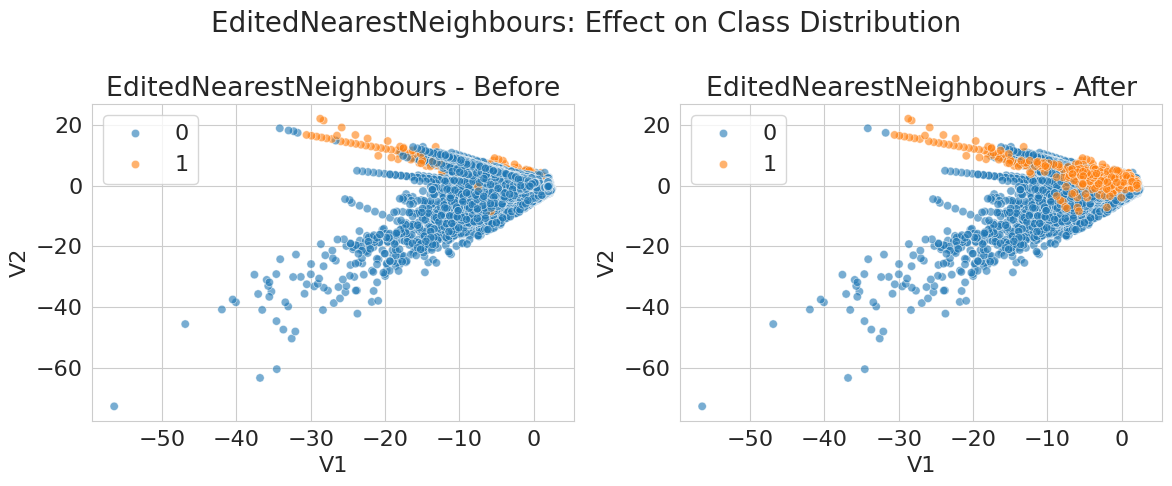

--- Evaluating SMOTEENN ---
Stratification class balance before SMOTEENN [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  SMOTEENN [class, frequency]: (array([0, 1]), array([282832, 283253]))


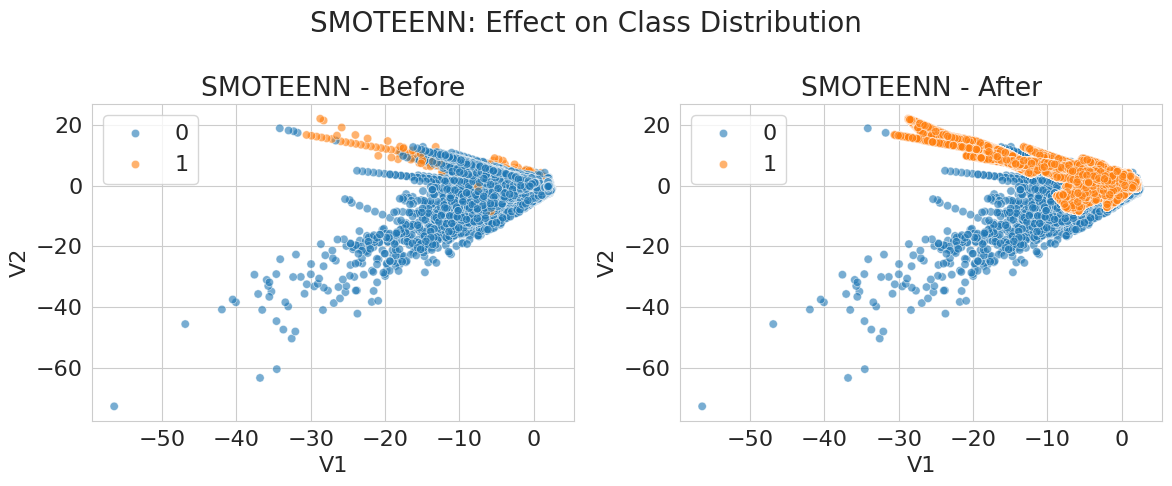

--- Evaluating SMOTETomek ---
Stratification class balance before SMOTETomek [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  SMOTETomek [class, frequency]: (array([0, 1]), array([283253, 283253]))


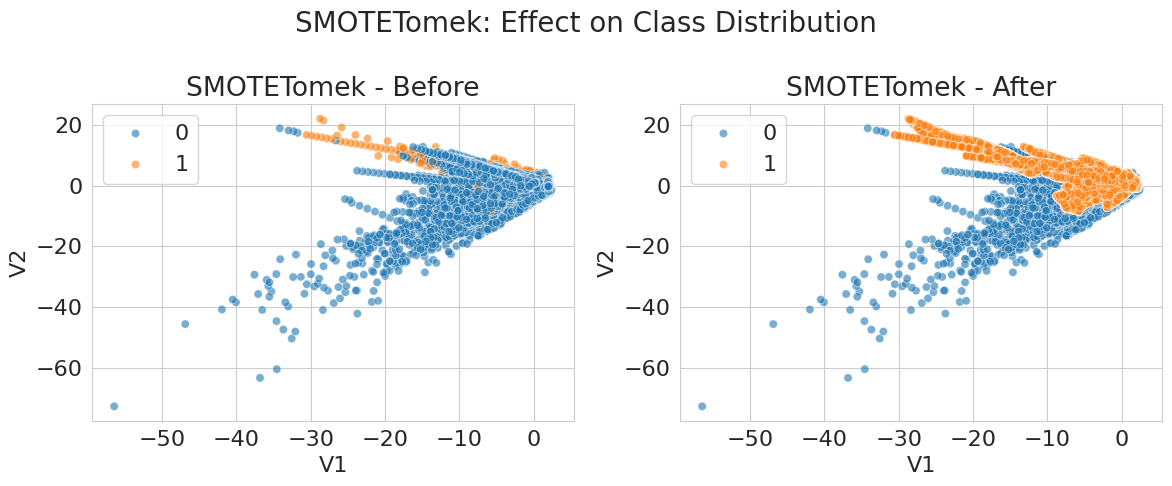

--- Evaluating Under05_SMOTEENN ---
Stratification class balance before Under05_SMOTEENN [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  Under05_SMOTEENN [class, frequency]: (array([0, 1]), array([9156, 9449]))


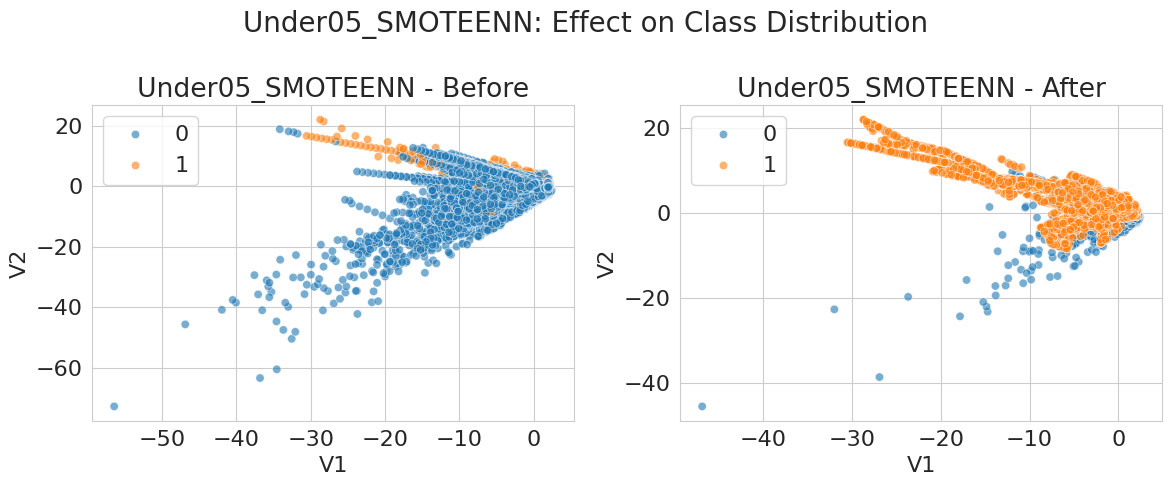

--- Evaluating Under10_SMOTEENN ---
Stratification class balance before Under10_SMOTEENN [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  Under10_SMOTEENN [class, frequency]: (array([0, 1]), array([4507, 4715]))


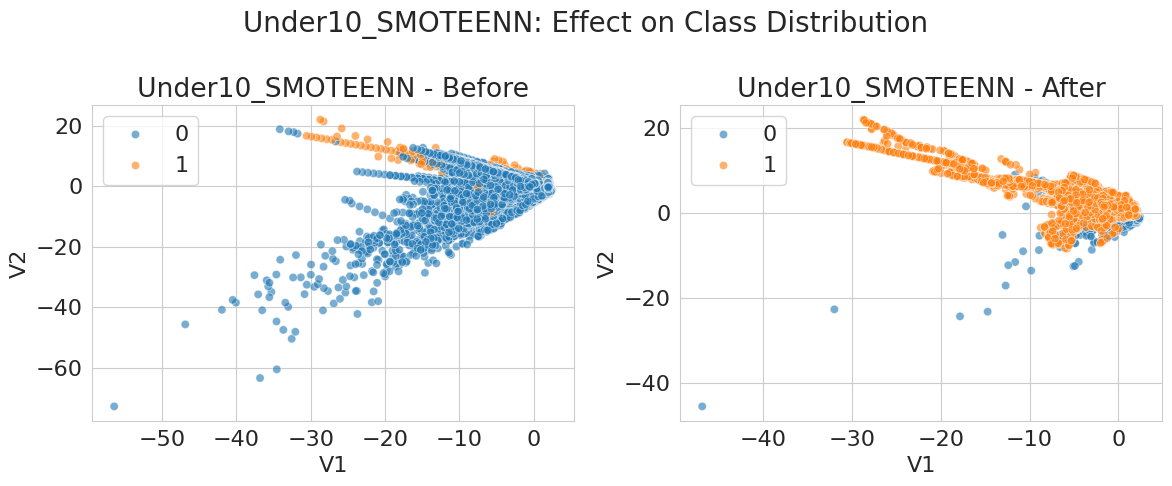

--- Evaluating Under20_SMOTEENN ---
Stratification class balance before Under20_SMOTEENN [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  Under20_SMOTEENN [class, frequency]: (array([0, 1]), array([2193, 2323]))


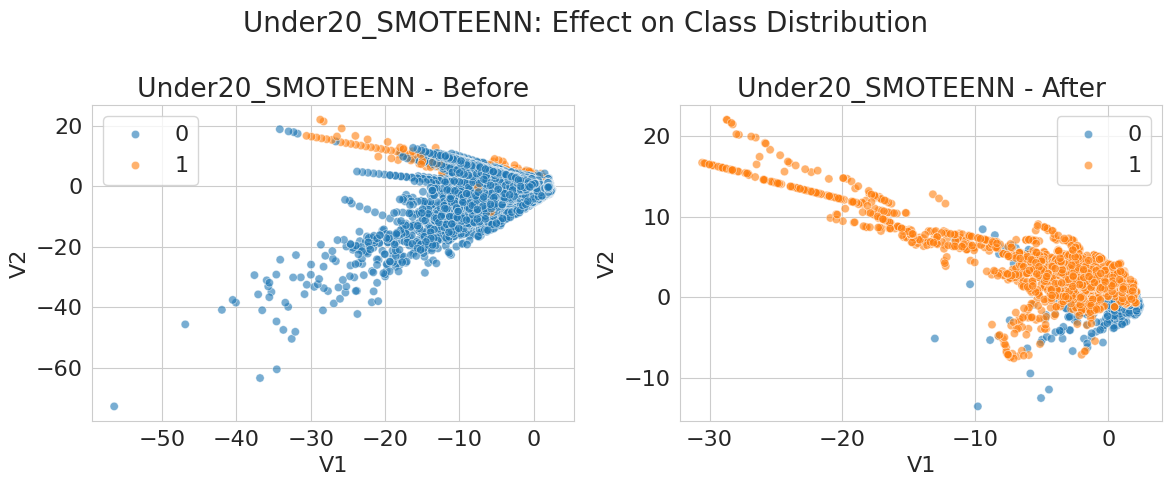

--- Evaluating ClusterCentroids_SMOTEENN ---
Stratification class balance before ClusterCentroids_SMOTEENN [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  ClusterCentroids_SMOTEENN [class, frequency]: (array([0, 1]), array([430, 379]))


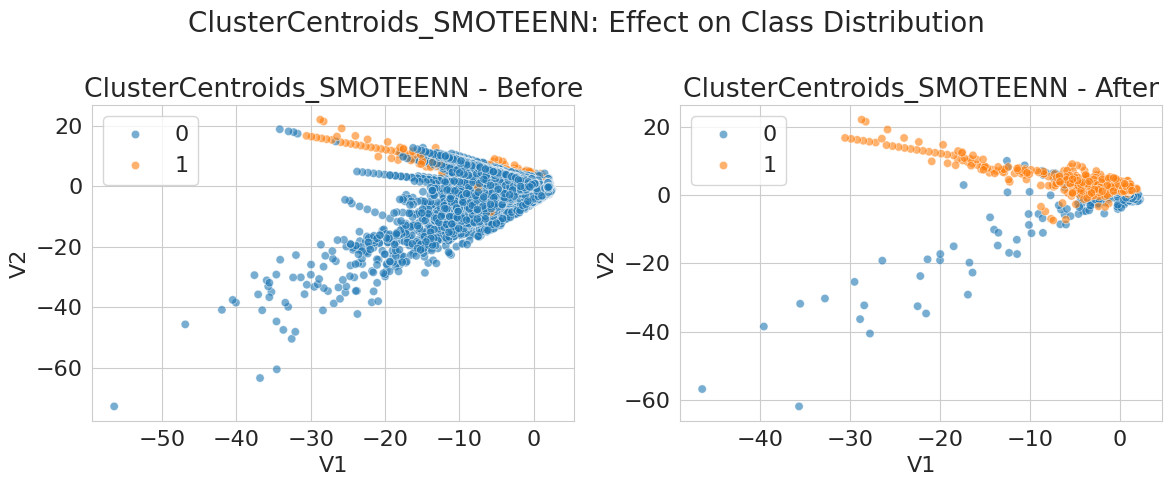

--- Evaluating OSS_SMOTE ---
Stratification class balance before OSS_SMOTE [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  OSS_SMOTE [class, frequency]: (array([0, 1]), array([264145, 264145]))


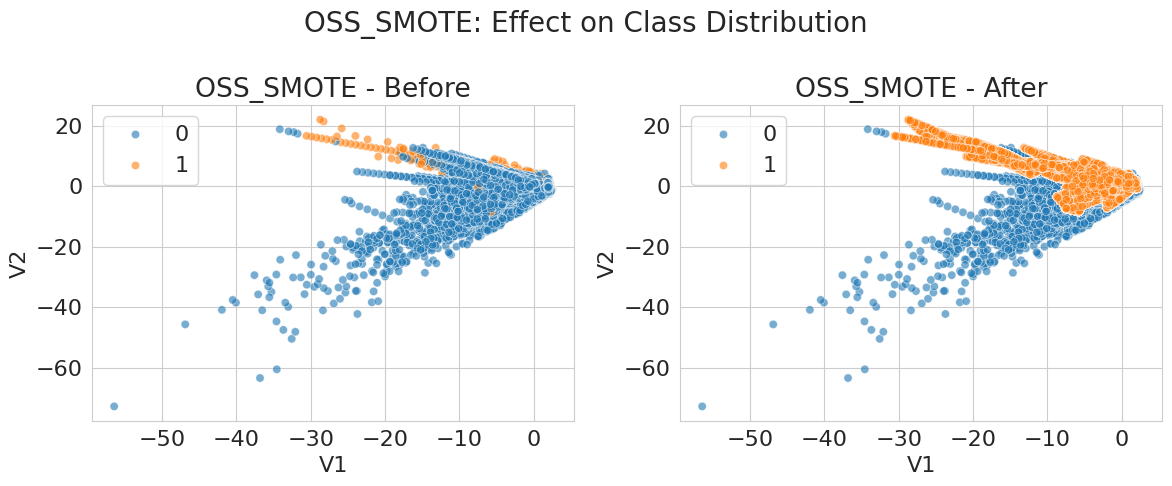

--- Evaluating Tomek_SMOTE ---
Stratification class balance before Tomek_SMOTE [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  Tomek_SMOTE [class, frequency]: (array([0, 1]), array([283231, 283231]))


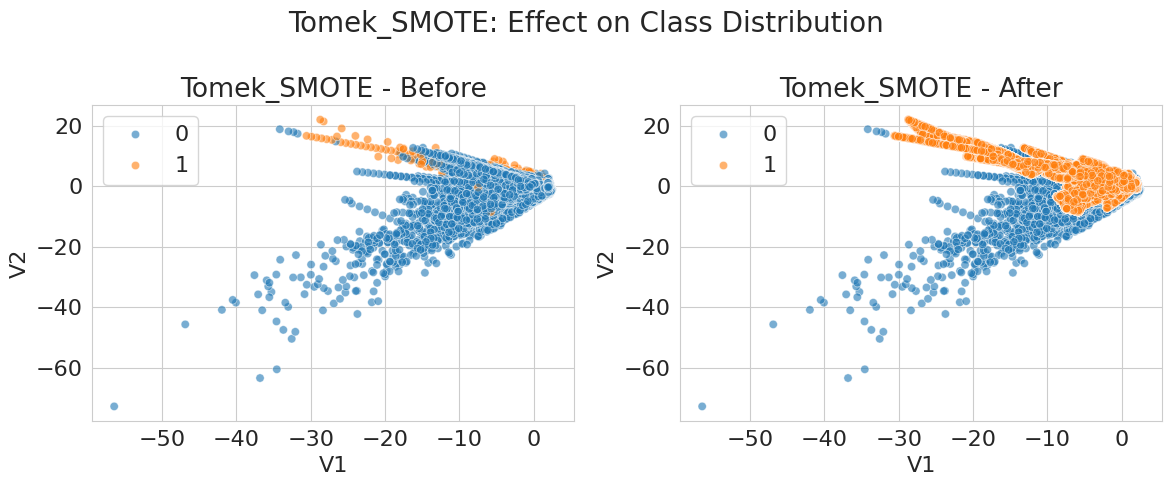

--- Evaluating NCR_SMOTE ---
Stratification class balance before NCR_SMOTE [class, frequency]: (array([0, 1]), array([283253,    473]))
Stratification class balance after  NCR_SMOTE [class, frequency]: (array([0, 1]), array([282991, 282991]))


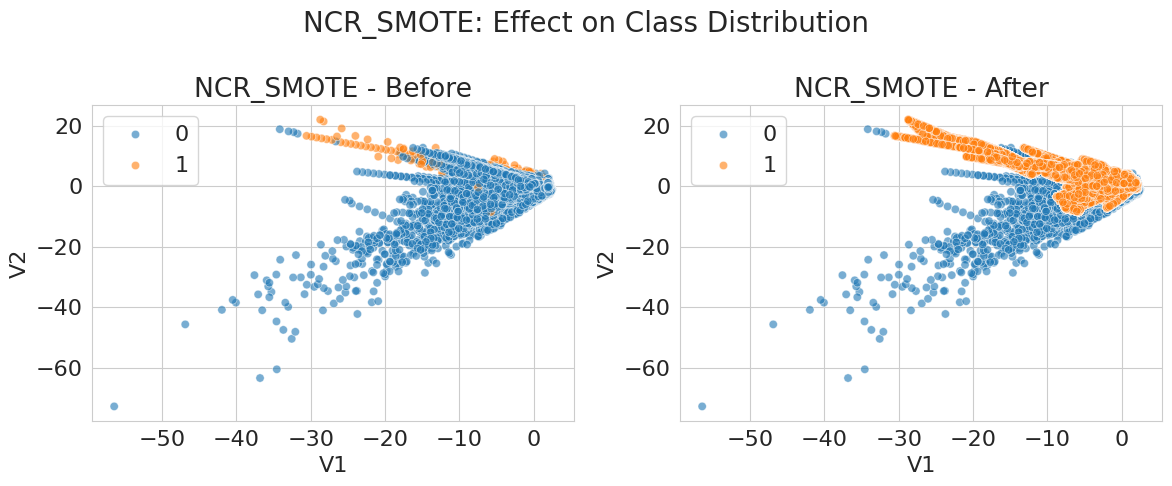

In [12]:
for name, resampler in resamplers.items():
    print(f"--- Evaluating {name} ---")

    # Visualize before/after imbalancing techniques
    visualize_resampling_effect(X, y, resampler, column_names, name)

    # Build the full pipeline (imbalance method + preprocessing + classifier)
    if isinstance(resampler, list):
        resample_steps = resampler
    else:
        resample_steps = [("resample", resampler)]

    model, _ = get_base_model_and_search_space("XGBClassifier",
                                               random_state=RANDOM_STATE)

    model_pipeline = build_base_model_pipeline(
        estimator=model,
        numerical_columns_to_scale=numerical_features_indices,
        k_best=K_BEST_TO_KEEP
    )

    full_pipeline = ImbPipeline(
        resample_steps +
        [("model", model_pipeline)]
    )

    # Evaluate the full pipeline by StratifiedKFold (k=5)
    scores = cross_validate(
        full_pipeline,
        X,
        y,
        cv=cv,
        scoring=["roc_auc", "f1", "precision", "recall"],
        n_jobs=-1
    )

    results.append({
        "Technique": name,
        "ROC AUC (mean ± std)": f"{np.mean(scores['test_roc_auc']):.4f} ± {np.std(scores['test_roc_auc']):.4f}",
        "F1 (mean ± std)": f"{np.mean(scores['test_f1']):.4f} ± {np.std(scores['test_f1']):.4f}",
        "Precision (mean ± std)": f"{np.mean(scores['test_precision']):.4f} ± {np.std(scores['test_precision']):.4f}",
        "Recall (mean ± std)": f"{np.mean(scores['test_recall']):.4f} ± {np.std(scores['test_recall']):.4f}",
    })

In [13]:
results_df = pd.DataFrame(results).sort_values(by=["ROC AUC (mean ± std)",
                                                   "F1 (mean ± std)"],
                                               ascending=False)
results_df

,Technique,ROC AUC (mean ± std),F1 (mean ± std),Precision (mean ± std),Recall (mean ± std)
8,Under10_SMOTEENN,0.9815 ± 0.0060,0.1568 ± 0.0176,0.0861 ± 0.0105,0.8901 ± 0.0125
7,Under05_SMOTEENN,0.9804 ± 0.0072,0.2414 ± 0.0092,0.1397 ± 0.0064,0.8922 ± 0.0139
5,SMOTEENN,0.9777 ± 0.0079,0.7379 ± 0.0167,0.6517 ± 0.0299,0.8520 ± 0.0135
9,Under20_SMOTEENN,0.9776 ± 0.0082,0.1074 ± 0.0135,0.0571 ± 0.0076,0.9112 ± 0.0196
13,NCR_SMOTE,0.9767 ± 0.0087,0.7546 ± 0.0173,0.6834 ± 0.0301,0.8436 ± 0.0153
0,SMOTE,0.9763 ± 0.0074,0.7787 ± 0.0161,0.7239 ± 0.0276,0.8436 ± 0.0182
6,SMOTETomek,0.9763 ± 0.0074,0.7787 ± 0.0161,0.7239 ± 0.0276,0.8436 ± 0.0182
12,Tomek_SMOTE,0.9745 ± 0.0085,0.7738 ± 0.0132,0.7172 ± 0.0278,0.8415 ± 0.0200
1,ADASYN,0.9738 ± 0.0071,0.7227 ± 0.0111,0.6414 ± 0.0193,0.8287 ± 0.0220
11,OSS_SMOTE,0.9736 ± 0.0101,0.7695 ± 0.0098,0.7156 ± 0.0175,0.8329 ± 0.0186
